# imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
from tensorflow import keras
import math as mt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# read csv

In [29]:
data = pd.read_csv("NSE-TATAGLOBAL.csv")

# data exploration and cleaning

In [30]:
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [32]:
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [33]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>,
        <Axes: title={'center': 'Low'}>],
       [<Axes: title={'center': 'Last'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Total Trade Quantity'}>],
       [<Axes: title={'center': 'Turnover (Lacs)'}>, <Axes: >, <Axes: >]],
      dtype=object)

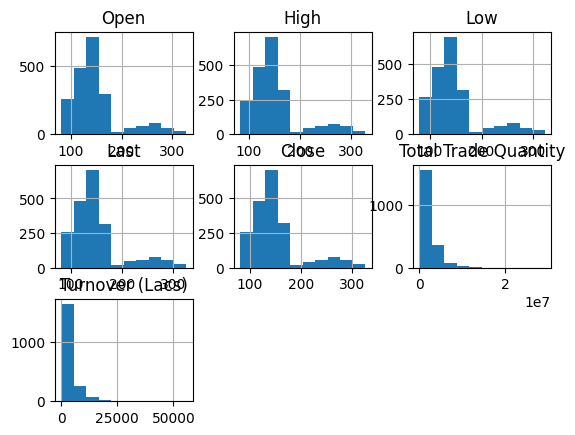

In [34]:
data.hist()

In [35]:
srt=data.sort_values(by='Date')
srt.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [36]:
srt.reset_index(inplace=True) 

In [37]:
srt.head()

,index,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
1,2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2,2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
3,2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
4,2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


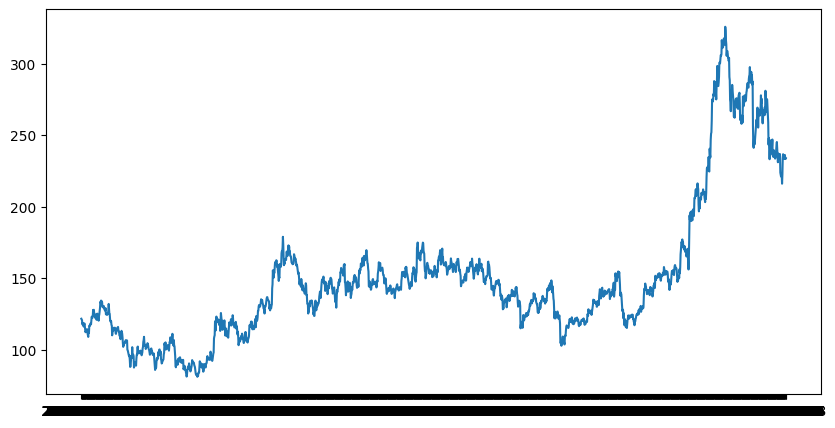

In [57]:
plt.figure(figsize=(10,5))
plt.plot(srt['Date'],srt['Close']) 

In [39]:

close_srt = srt['Close']
scaler = MinMaxScaler(feature_range=(0,1)) 
close_srt = scaler.fit_transform(np.array(close_srt).reshape(-1, 1))
close_srt

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

# training model

In [40]:
train_size = int(len(close_srt)*0.7)
test_size = len(close_srt) - train_size
train_data,test_data = close_srt[0:train_size,:],close_srt[train_size:len(close_srt),:1]

In [41]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [42]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [43]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
model.fit(X_train,y_train,validation_split=0.1,epochs=60,batch_size=64,verbose=1)

Epoch 1/60
19/19 [==============================] - 3s 99ms/step - loss: 0.0115 - val_loss: 0.0012
Epoch 2/60
19/19 [==============================] - 2s 86ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 3/60
19/19 [==============================] - 2s 87ms/step - loss: 9.1386e-04 - val_loss: 0.0012
Epoch 4/60
19/19 [==============================] - 2s 86ms/step - loss: 8.4872e-04 - val_loss: 0.0010
Epoch 5/60
19/19 [==============================] - 2s 81ms/step - loss: 7.8711e-04 - val_loss: 0.0010
Epoch 6/60
19/19 [==============================] - 2s 83ms/step - loss: 7.4922e-04 - val_loss: 0.0010
Epoch 7/60
19/19 [==============================] - 2s 87ms/step - loss: 7.5123e-04 - val_loss: 9.3799e-04
Epoch 8/60
19/19 [==============================] - 2s 84ms/step - loss: 7.1963e-04 - val_loss: 9.1605e-04
Epoch 9/60
19/19 [==============================] - 2s 80ms/step - loss: 7.0422e-04 - val_loss: 8.9922e-04
Epoch 10/60
19/19 [==============================] - 2s 80ms/step - l

# predicting

In [47]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

16/16 [==============================] - 0s 12ms/step


In [48]:
train_predict = scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [49]:
mt.sqrt(mean_squared_error(y_train,train_predict))


133.80327469545674

In [50]:
mt.sqrt(mean_squared_error(y_test,test_predict))

199.33869733337323

# prediction vs actual

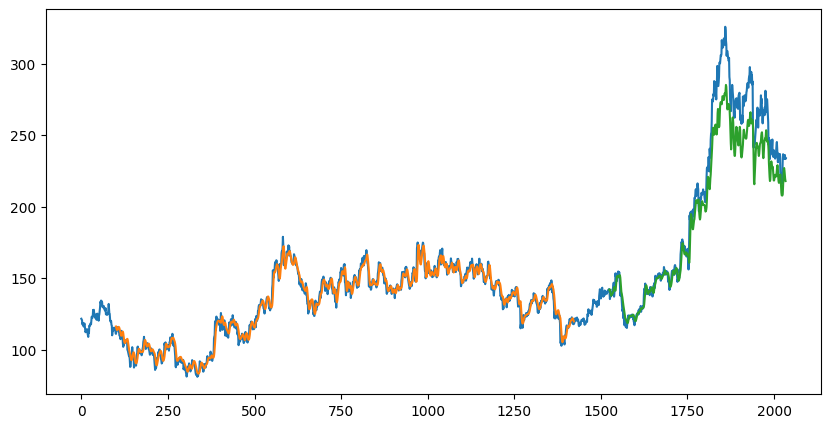

In [52]:

look_back=100

trainPredictPlot = np.empty_like(close_srt)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(close_srt)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(close_srt)-1, :] = test_predict

plt.figure(figsize=(10,5))
plt.plot(scaler.inverse_transform(close_srt))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()